In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import tensorflow as tf

In [39]:
data = {'Date':['2024-01-01','2024-01-02','2024-01-03','2024-01-04','2024-01-05'],
       'Temp': [22,21,23,24,22]}

In [40]:
df = pd.DataFrame(data)
df['Date']=pd.to_datetime(df['Date'])
df.set_index ('Date', inplace=True)

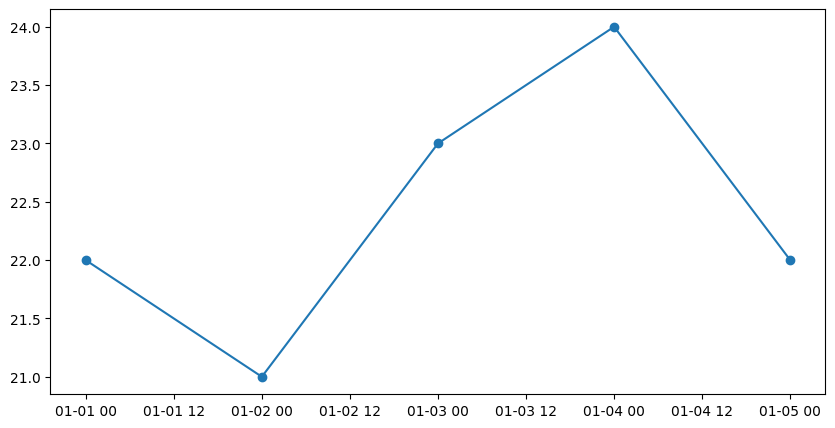

In [41]:
plt.figure(figsize= (10,5))
plt.plot(df.index, df['Temp'], marker = 'o', linestyle ='-')

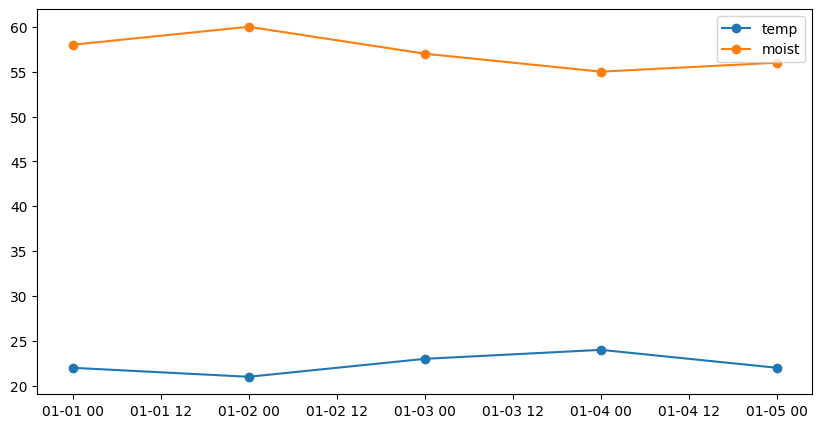

In [42]:
data = {'Date':['2024-01-01','2024-01-02','2024-01-03','2024-01-04','2024-01-05'],
       'Temp': [22,21,23,24,22],
        'Humidity': [58,60,57,55,56]
        }

df = pd.DataFrame(data)
df['Date']=pd.to_datetime(df['Date'])
df.set_index ('Date', inplace=True)

plt.figure(figsize= (10,5))
plt.plot(df.index, df['Temp'], marker = 'o', linestyle ='-', label = 'temp')
plt.plot(df.index, df['Humidity'], marker = 'o', linestyle ='-', label = 'moist')
plt.legend()


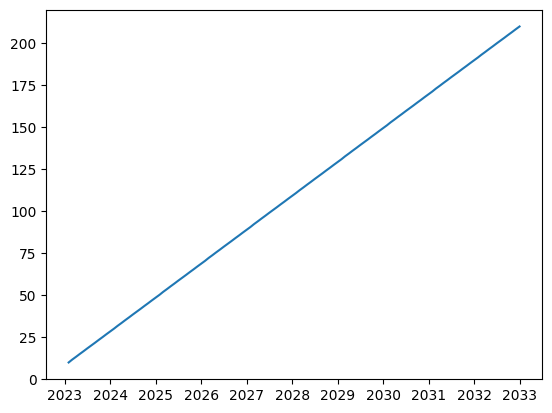

In [43]:
time = pd.date_range('2023-01-01',periods =120 ,freq ='ME')
trend = np.linspace(10,210, num=120)

df =pd.DataFrame({'Trend': trend}, index =time)

plt.plot(df.index, df['Trend'])

In [44]:
seasonality  =10+125*np.sin(2*np.pi*time.month/12)

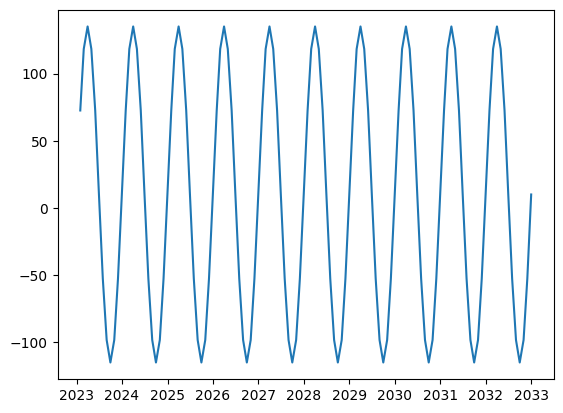

In [45]:
df = pd.DataFrame({'Seasonality':seasonality}, index =time)
plt.plot(df.index, df['Seasonality'])

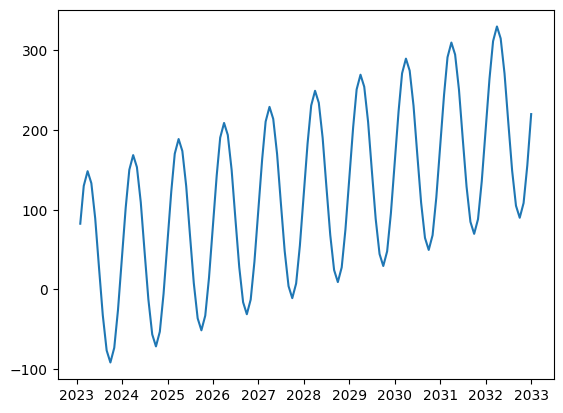

In [46]:
trend_seasonality =trend + seasonality
df = pd.DataFrame({'trend_seasonality':trend_seasonality}, index =time)
plt.plot(df.index, df['trend_seasonality'])

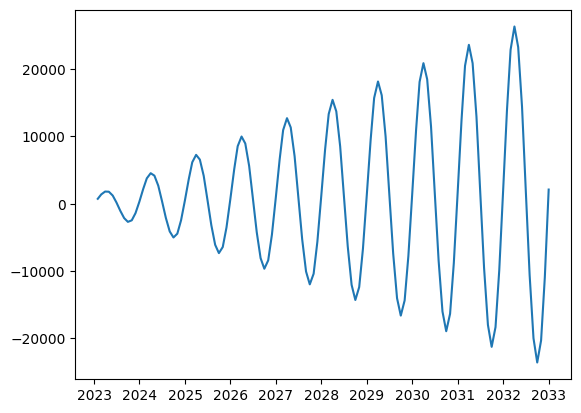

In [20]:
trend_seasonality =trend * seasonality
df = pd.DataFrame({'trend_seasonality':trend_seasonality}, index =time)
plt.plot(df.index, df['trend_seasonality'])

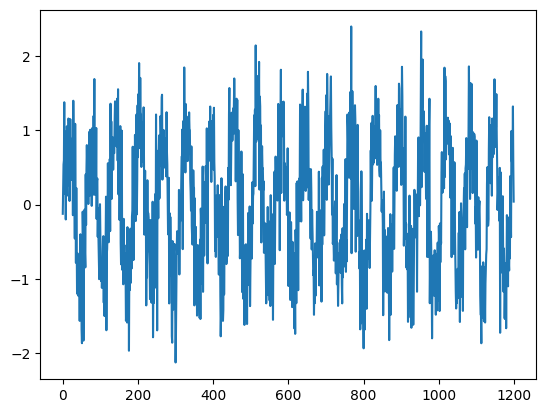

In [22]:
#noise
time = np.arange(1200)
noise = np.random.normal(scale=0.5, size = 1200)
series = np.sin(0.1*time)+noise

plt.plot(time, series)

In [23]:
import yfinance as yf

In [35]:
symbols = ['BTC-USD']#,'^GSPC']
start_date = '2013-04-01'
end_date = '2023-04-01'
data = yf.download(symbols, start = start_date, end =end_date)


[*********************100%***********************]  1 of 1 completed


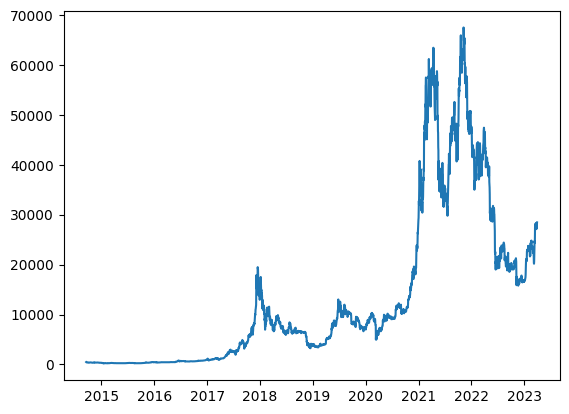

In [37]:
plt.plot(data['Close'])

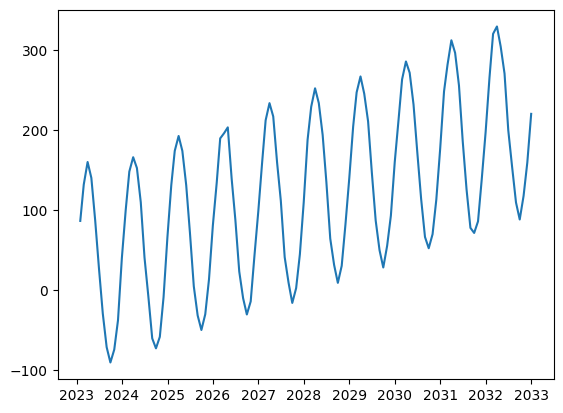

In [56]:
noise = np.random.normal(scale=5, size = 120)

trend_seasonality =trend + seasonality
df = pd.DataFrame({'trend_seasonality_noise':trend_seasonality+noise}, index =time)
plt.plot(df.index, df['trend_seasonality_noise'])

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

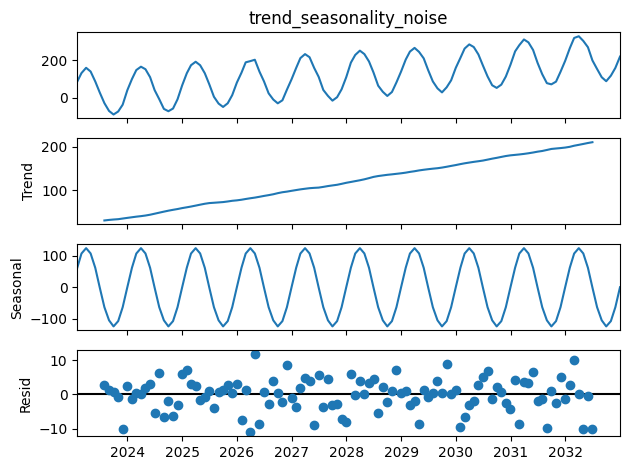

In [57]:
#דוגמא טובה
result= seasonal_decompose(df['trend_seasonality_noise'],
                           model = 'additive',
                           period =12) #עבדנו במחזוריות של 12 חודשים בשנה

result.plot()
plt.show()

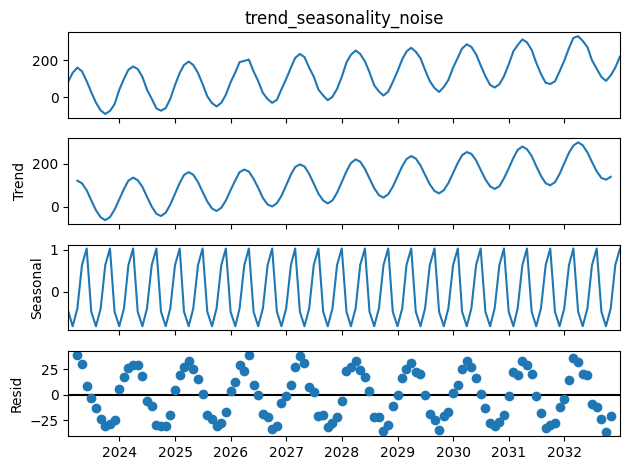

In [58]:
#דוגמא לא טובה - מה קורה כשהמחזור לא מתאים לנתונים
result= seasonal_decompose(df['trend_seasonality_noise'],
                           model = 'additive',
                           period =5)

result.plot()
plt.show()

In [60]:
time = np.arange(20) #20 נקודות זמן
trend = time*2 #עליה בקצב קבוע
seasonality = 5*np.sin(2*np.pi*time/5) #מחזוריות כל 5 צעדים
series = trend + seasonality



In [61]:
df = pd.DataFrame({'Time':time, 'Value':series})


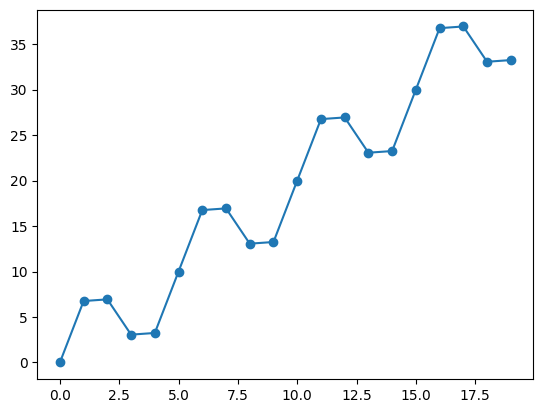

In [62]:
plt.plot(df["Time"], df["Value"],
         marker = 'o')


In [63]:
#פונקציה
def create_windows (series, window_size):
  X,y =[],[]
  for i in range (len(series)-window_size):
    X.append(series[i:i+window_size])#צעדים של חלון window_size
    y.append(series[i+window_size])
  return np.array(X), np.array(y)

In [64]:
window_size = 5
X,y = create_windows (series,window_size)

In [66]:
print(f"first window {X[0]} label: {y[0]}")
print(f"second window {X[1]} label: {y[1]}")
print(f"3rd   window {X[2]} label: {y[2]}")



first window [0.         6.75528258 6.93892626 3.06107374 3.24471742] label: 9.999999999999998
second window [ 6.75528258  6.93892626  3.06107374  3.24471742 10.        ] label: 16.755282581475768
3rd   window [ 6.93892626  3.06107374  3.24471742 10.         16.75528258] label: 16.938926261462367


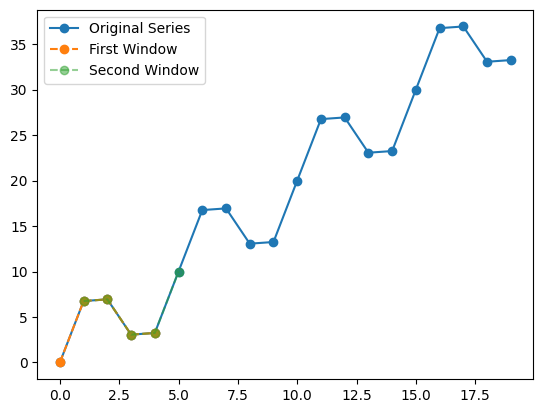

In [72]:
plt.plot(df["Time"], df["Value"], marker='o', linestyle='-',
         label="Original Series")
# סימון החלון הראשון
plt.plot(df["Time"][:window_size], X[0], marker='o', linestyle = '--',
         label="First Window")
# סימון החלון השני
plt.plot(df["Time"][1:window_size+1], X[1], marker='o',
         alpha =0.5, linestyle = '--', label="Second Window")
plt.legend()

In [76]:
#tf windows
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1,
                             drop_remainder=True)  # יצירת חלונות עם חפיפה
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))  # הפיכת החלונות לרשימה אחת
    dataset = dataset.map(lambda window: (window[:-1],
                                          window[-1]))  # הפרדת X (כל החלון) ו- y (הערך הבא)
    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(1)  # עירבוב ושיפור ביצועים
    return dataset

# הגדרת גודל חלון ובאטצ'
window_size = 5
batch_size = 2  # אפשר לשנות כדי לראות איך זה משפיע

# יצירת החלונות
dataset = windowed_dataset(series, window_size, batch_size)

# הצגת שני חלונות ראשונים מהסט
for x, y in dataset.take(2):
    print("X (window):", x.numpy())  # חלון הנתונים
    print("y (label):", y.numpy())  # הערך הבא אחרי החלון
    print()

X (window): [[10.         16.75528258 16.93892626 13.06107374 13.24471742]
 [16.75528258 16.93892626 13.06107374 13.24471742 20.        ]]
y (label): [20.         26.75528258]

X (window): [[13.24471742 20.         26.75528258 26.93892626 23.06107374]
 [ 3.06107374  3.24471742 10.         16.75528258 16.93892626]]
y (label): [23.24471742 13.06107374]

